## Notebook To Display CO2 Data
Catherine Kuhn , 2018-09-11

## Load Libraries and Data

In [1]:
# start with same libraries as vector tutorial
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimeSliderChoropleth

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

/root/miniconda/envs/vectorenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%run -i load_data.py

## View Data

In [3]:
df = co2_data_table
df.head(1)

,Reference,Site Type,Latitude,Longitude,DateTime,Altitude,Discharge,Stream Slope,Width,Depth,...,Air Temperature,DO,Chl a,CO2,k,k600,CO2 Flux,CO2 Flux.1,Source,geometry
0,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,28.1,NaN,NaN,140.5,NaN,-18.104,1381.28,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066)


## How many measurements per citation? (Count)

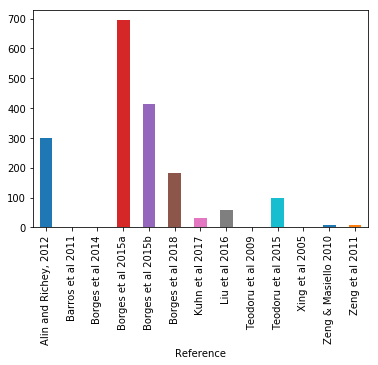

In [4]:
df.groupby(['Reference'])['CO2'].count().plot(kind = 'bar')

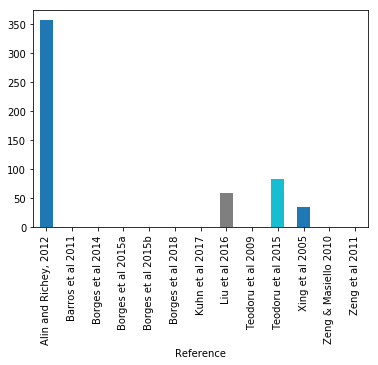

In [5]:
df.groupby(['Reference'])['CO2 Flux'].count().plot(kind = 'bar')

## What is the median Co2 value for each given study? 

Text(0,0.5,'CO2 uatm')

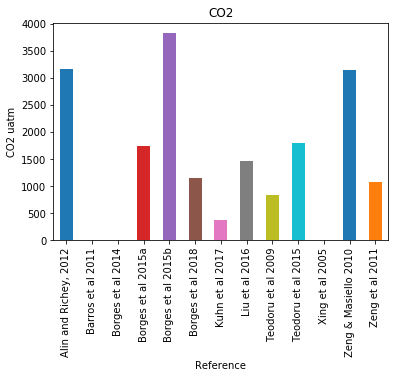

In [6]:
df.groupby(['Reference'])['CO2'].median().plot(kind = 'bar')
plt.title('CO2')
plt.ylabel('CO2 uatm')

Text(0,0.5,'CO2 Flux g C m-2 yr-1')

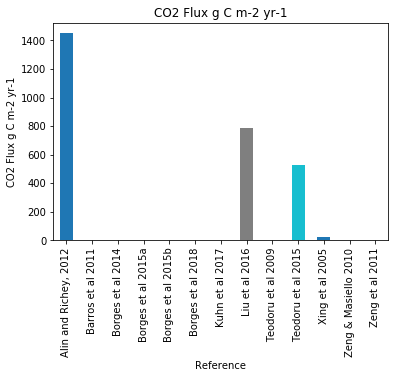

In [7]:
df.groupby(['Reference'])['CO2 Flux'].median().plot(kind = 'bar')
plt.title('CO2 Flux g C m-2 yr-1')
plt.ylabel('CO2 Flux g C m-2 yr-1')

## What is the distribution of pCo2 measurements?

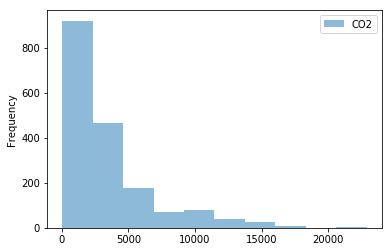

In [8]:
df2 = df[['CO2','Reference']]
df2.plot(kind='hist',  alpha=0.5)

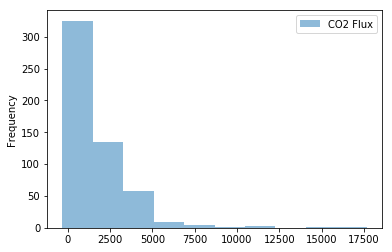

In [9]:
df2 = df[['CO2 Flux','Reference']]
df2.plot(kind='hist', alpha=0.5)

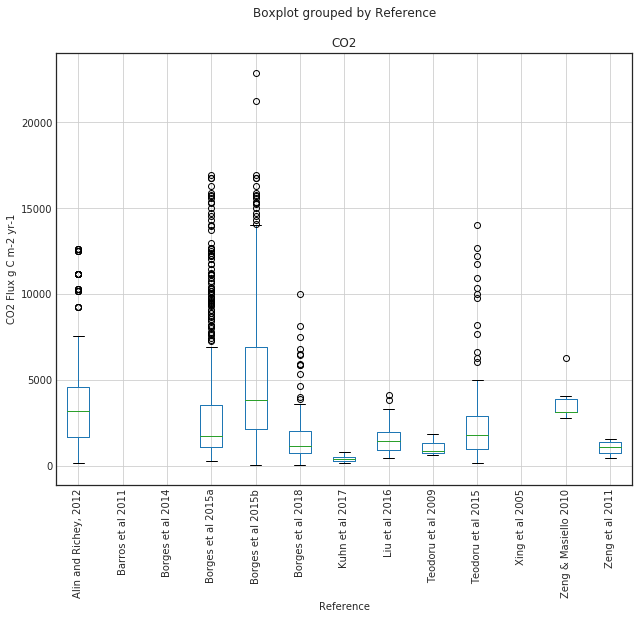

In [10]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
df.boxplot(column=['CO2'], by='Reference', ax=ax)
plt.xticks(rotation=90)
plt.ylabel('CO2 Flux g C m-2 yr-1')
plt.show()

## Bring in COSCAT regions

In [11]:
data_pth = "../data/hess_GIS/"

In [12]:
#continenal_shelf = gpd.read_file(os.path.join(data_pth, "Continental_Shelf.shp"))
coscat = gpd.read_file(os.path.join(data_pth, "Continents.shp"))
coscat.head(1)

,OBJECTID,COSCAT,MARCATS,geometry
0,1,1,20,(POLYGON ((-4.500000106346192 34.9999998785016...


### Check their projections

In [13]:
print(coscat.crs)
print(co2_geo_data_table.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [14]:
# How many COSCAT regions are there? 
len(coscat['COSCAT'].unique())

231

## Add sample points to COSCAT map

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

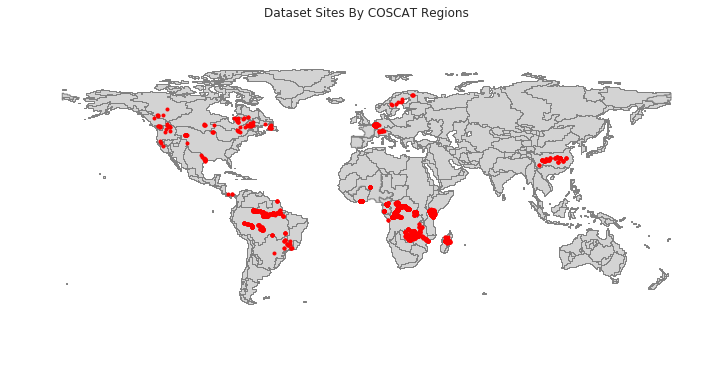

In [16]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Dataset Sites By COSCAT Regions')
coscat.plot(ax=ax, edgecolor='gray', facecolor='lightgrey')
co2_geo_data_table.plot(ax=ax, marker='.', color='r')
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

## Do spatial join

In [17]:
samples = gpd.sjoin(co2_geo_data_table, coscat, how="inner", op='intersects')
samples.head(1)

,Reference,Site Type,Latitude,Longitude,DateTime,Altitude,Discharge,Stream Slope,Width,Depth,...,k,k600,CO2 Flux,CO2 Flux.1,Source,geometry,index_right,OBJECTID,COSCAT,MARCATS
0,"Alin and Richey, 2012",small stream,-10.066,-67.606,20040701,150.0,NaN,NaN,NaN,NaN,...,NaN,-18.104,1381.28,NaN,"Alin, S.R., and J.E. Richey. 2012. LBA-ECO CD-...",POINT (-67.60599999999999 -10.066),38,39,1104,7


In [18]:
samples['COSCAT'].unique()

array([1104,  809,  815,  808, 1108,  825,  416,  821,  826,  805,  418,
        818,  830,  403,  405,  817,  834,  807, 1107, 1106,   14,    3,
         17,   15,   16,   11,    8,    9,    7,    6, 1326,  833])

In [19]:
#samples.plot(cmap='tab20', categorical = True, figsize=(10, 10));
#samples.plot(column='COSCAT', cmap='Set2', categorical=True,  edgecolor='black', figsize=(10, 10));

In [20]:
## Calculate the average CO2 value for each COSCAT value

In [33]:
coscat_co2_means = pd.DataFrame(samples.groupby(['COSCAT'])['CO2'].mean())
coscat_co2_means = coscat_co2_means.reset_index()
coscat_co2_means = coscat_co2_means.dropna()

coscat_fco2_means = pd.DataFrame(samples.groupby(['COSCAT'])['CO2 Flux'].mean())
coscat_fco2_means = coscat_fco2_means.reset_index()
coscat_fco2_means = coscat_fco2_means.dropna()

In [35]:
coscat_co2_values = coscat.merge(coscat_co2_means, on='COSCAT')
coscat_fco2_values = coscat.merge(coscat_fco2_means, on='COSCAT')

In [36]:
coscat_co2_values.head(1)
coscat_fco2_values.head(1)

,OBJECTID,COSCAT,MARCATS,geometry,CO2 Flux
0,39,1104,7,POLYGON ((-48.49999986153796 -1.00000000045025...,1950.840224


No handles with labels found to put in legend.


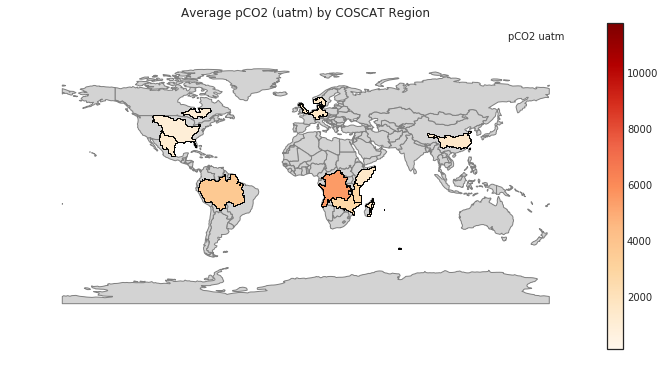

In [31]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Average pCO2 (uatm) by COSCAT Region')
world.plot(ax=ax, edgecolor='gray', facecolor='lightgrey')
coscat_values.plot(ax=ax, column='CO2', vmin = 132, vmax = 11772, cmap='OrRd', categorical=False, edgecolor='black', figsize=(10, 10), legend = True);
ax.legend(title="pCO2 uatm")
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

<img src="Raymond_2012_pCO2.png" alt="Raymond 2012 Original" style="width:600px;height:auto;">

KeyError: 'CO2 Flux'

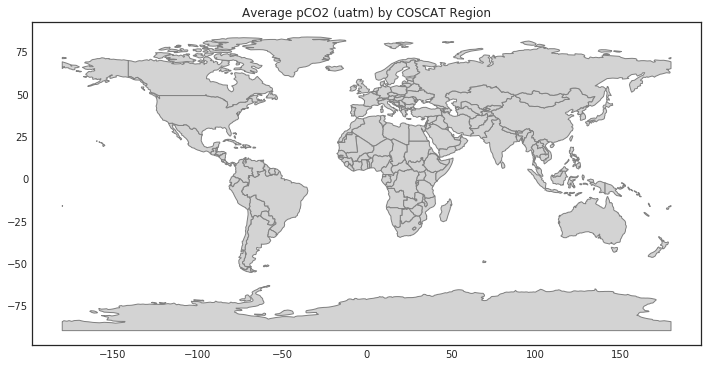

In [32]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Average pCO2 Flux by COSCAT Region')
world.plot(ax=ax, edgecolor='gray', facecolor='lightgrey')
coscat_fco2_values.plot(ax=ax, column='CO2 Flux', vmin = 132, vmax = 11772, cmap='OrRd', categorical=False, edgecolor='black', figsize=(10, 10), legend = True);
ax.legend(title="CO2 flux")
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

# Just Curious

In [ ]:
import numpy as np
x = np.log(df['CO2'])
y = np.log(df['Chl a'])
plt.scatter(x, y)

In [ ]:
df['Water Temperature'].hist()

In [ ]:
plt.scatter(df.CO2 , df['CO2 Flux'], c=df['Water Temperature'], cmap='jet')

plt.colorbar()

plt.xlabel('CO2 Concentration')
plt.ylabel('CO2 Flux')